# Install dependancy

In [ ]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import tqdm

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(torch. __version__)

2.0.0+cu118


In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Telecom/Airbus/Sentiment classification/Ternaire Sentiment Classification/reviews.csv')
df.shape

(12495, 12)

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [ ]:
# Let's have a look at the data
df['score'].value_counts()

5    2879
4    2775
1    2506
2    2344
3    1991
Name: score, dtype: int64

In [ ]:
# Let's check for missing values
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

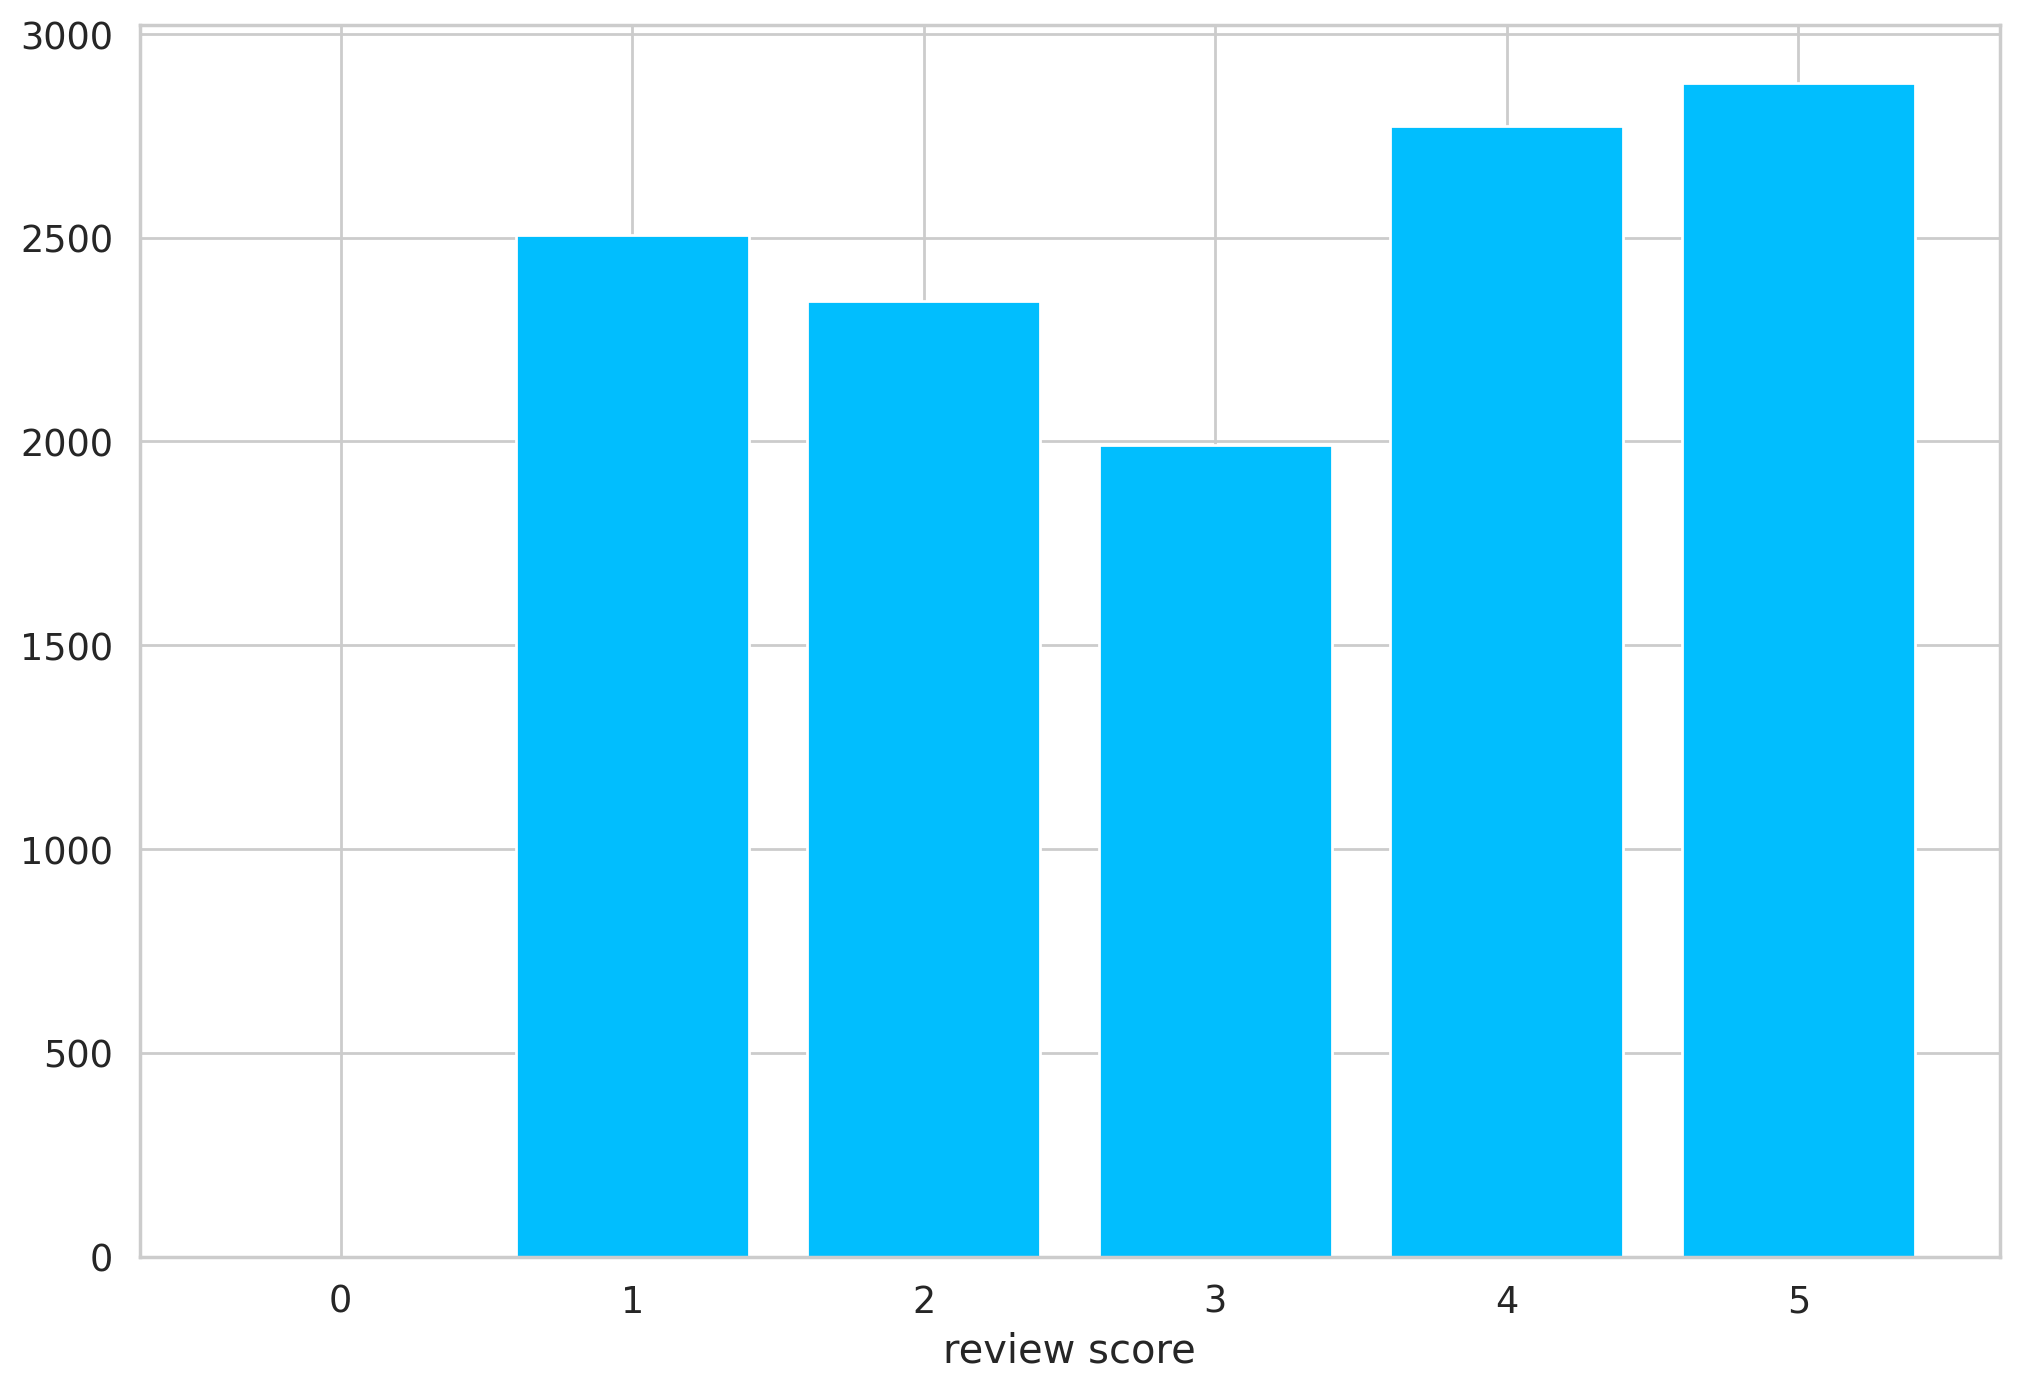

In [ ]:
# Let's have a look at the class balance.
counts = np.bincount(df['score'])
plt.bar(range(len(counts)), counts)
plt.xlabel('review score');

# Pre-processing

In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):

    rating = int(rating)

    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset
df['sentiment'] = df['score'].apply(to_sentiment)

Text(0.5, 0, 'review sentiment')

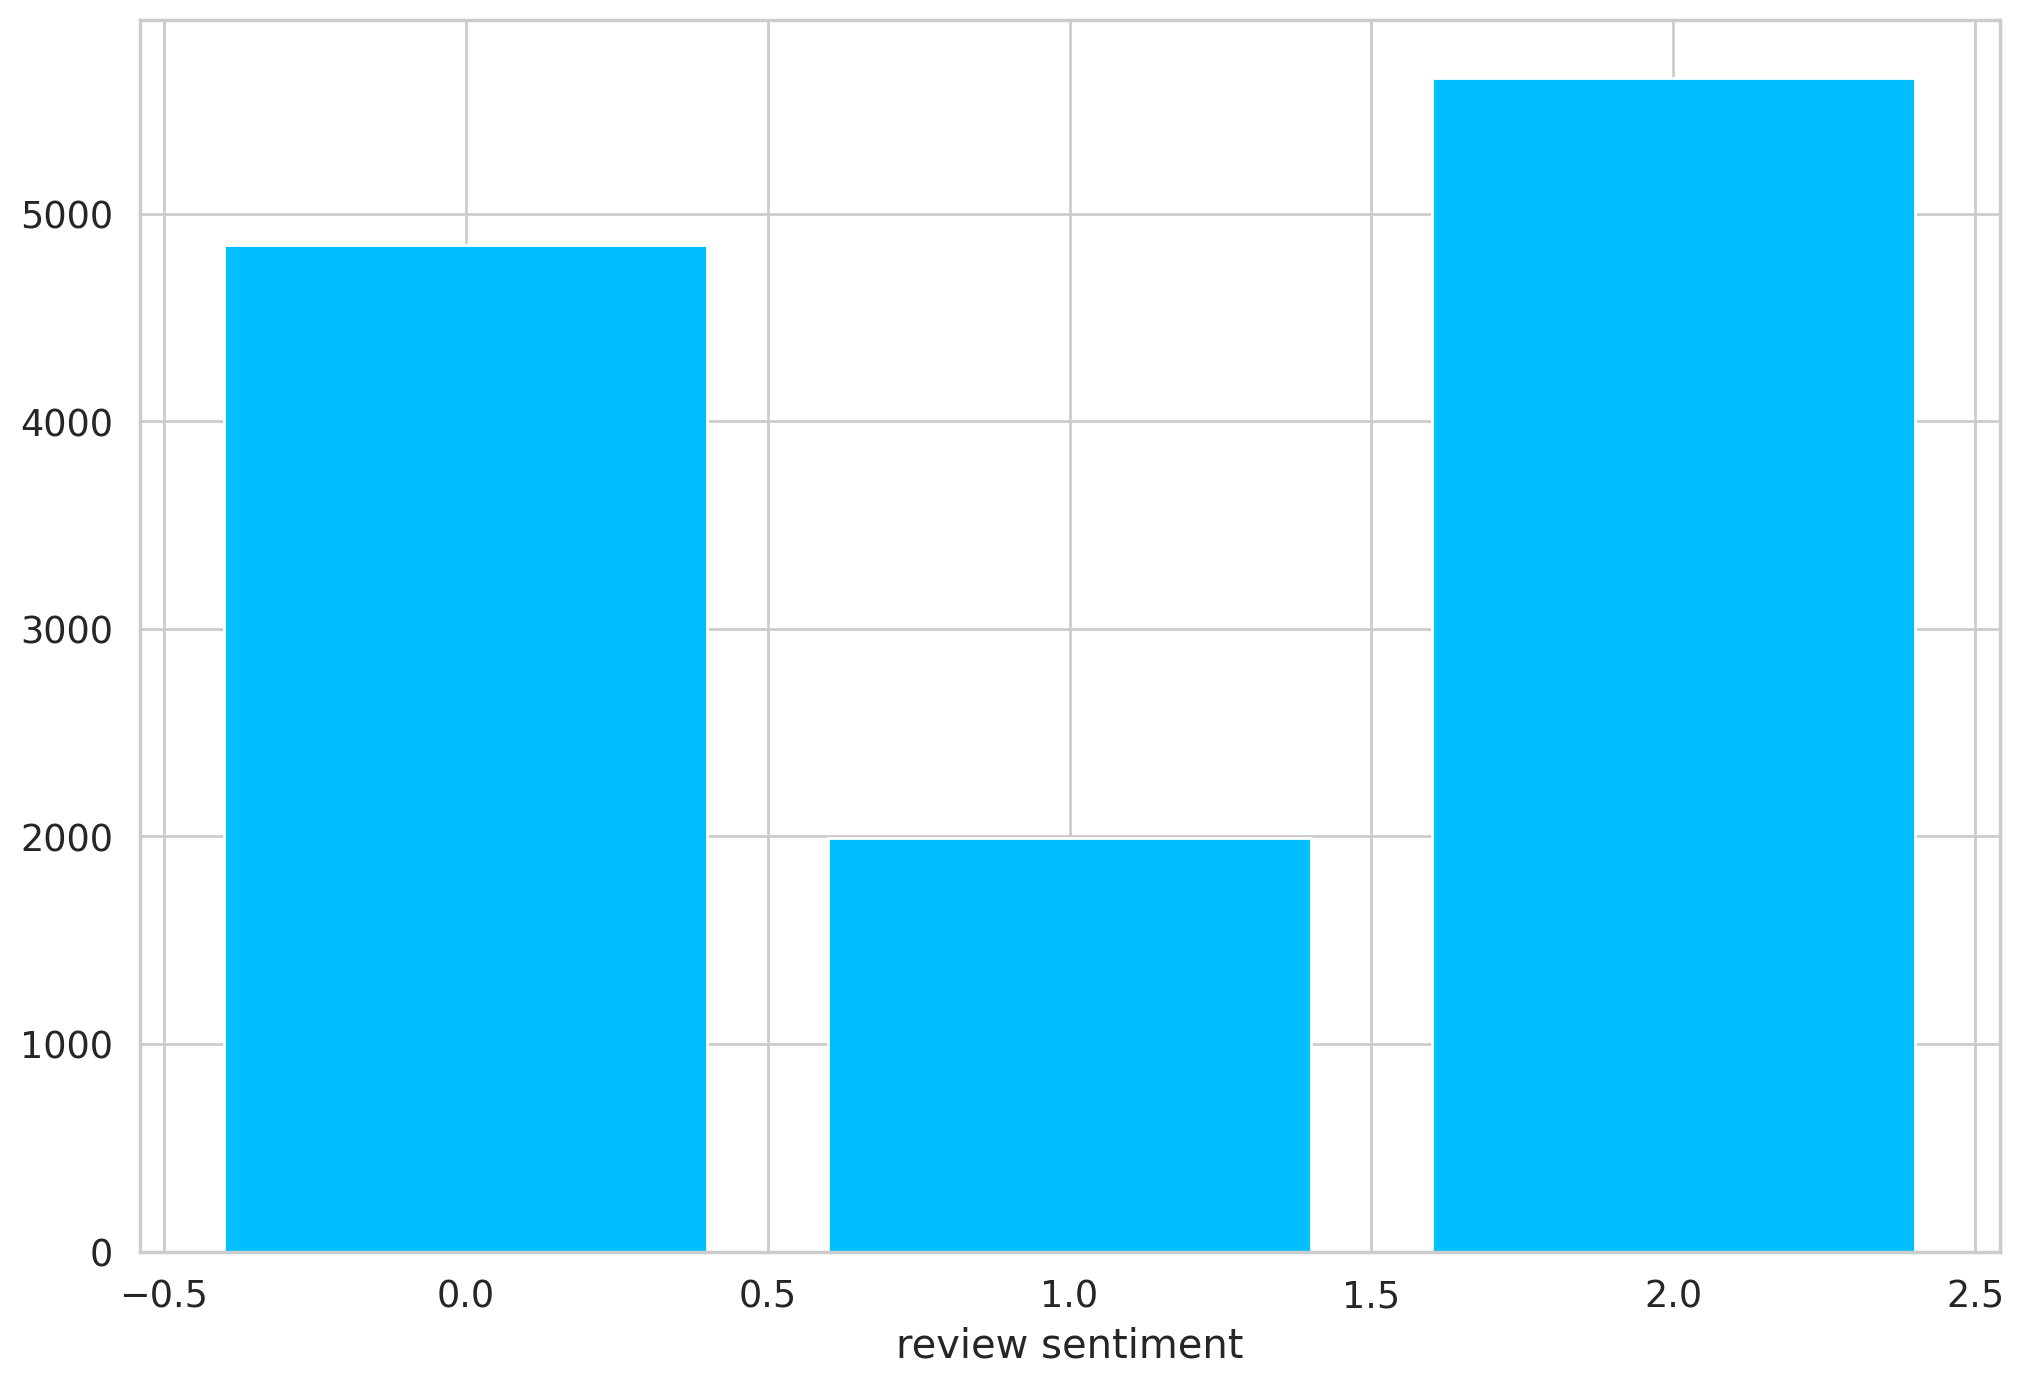

In [ ]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
counts = np.bincount(df['sentiment'])
plt.bar(range(len(counts)), counts)
plt.xlabel('review sentiment')

In [ ]:
# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

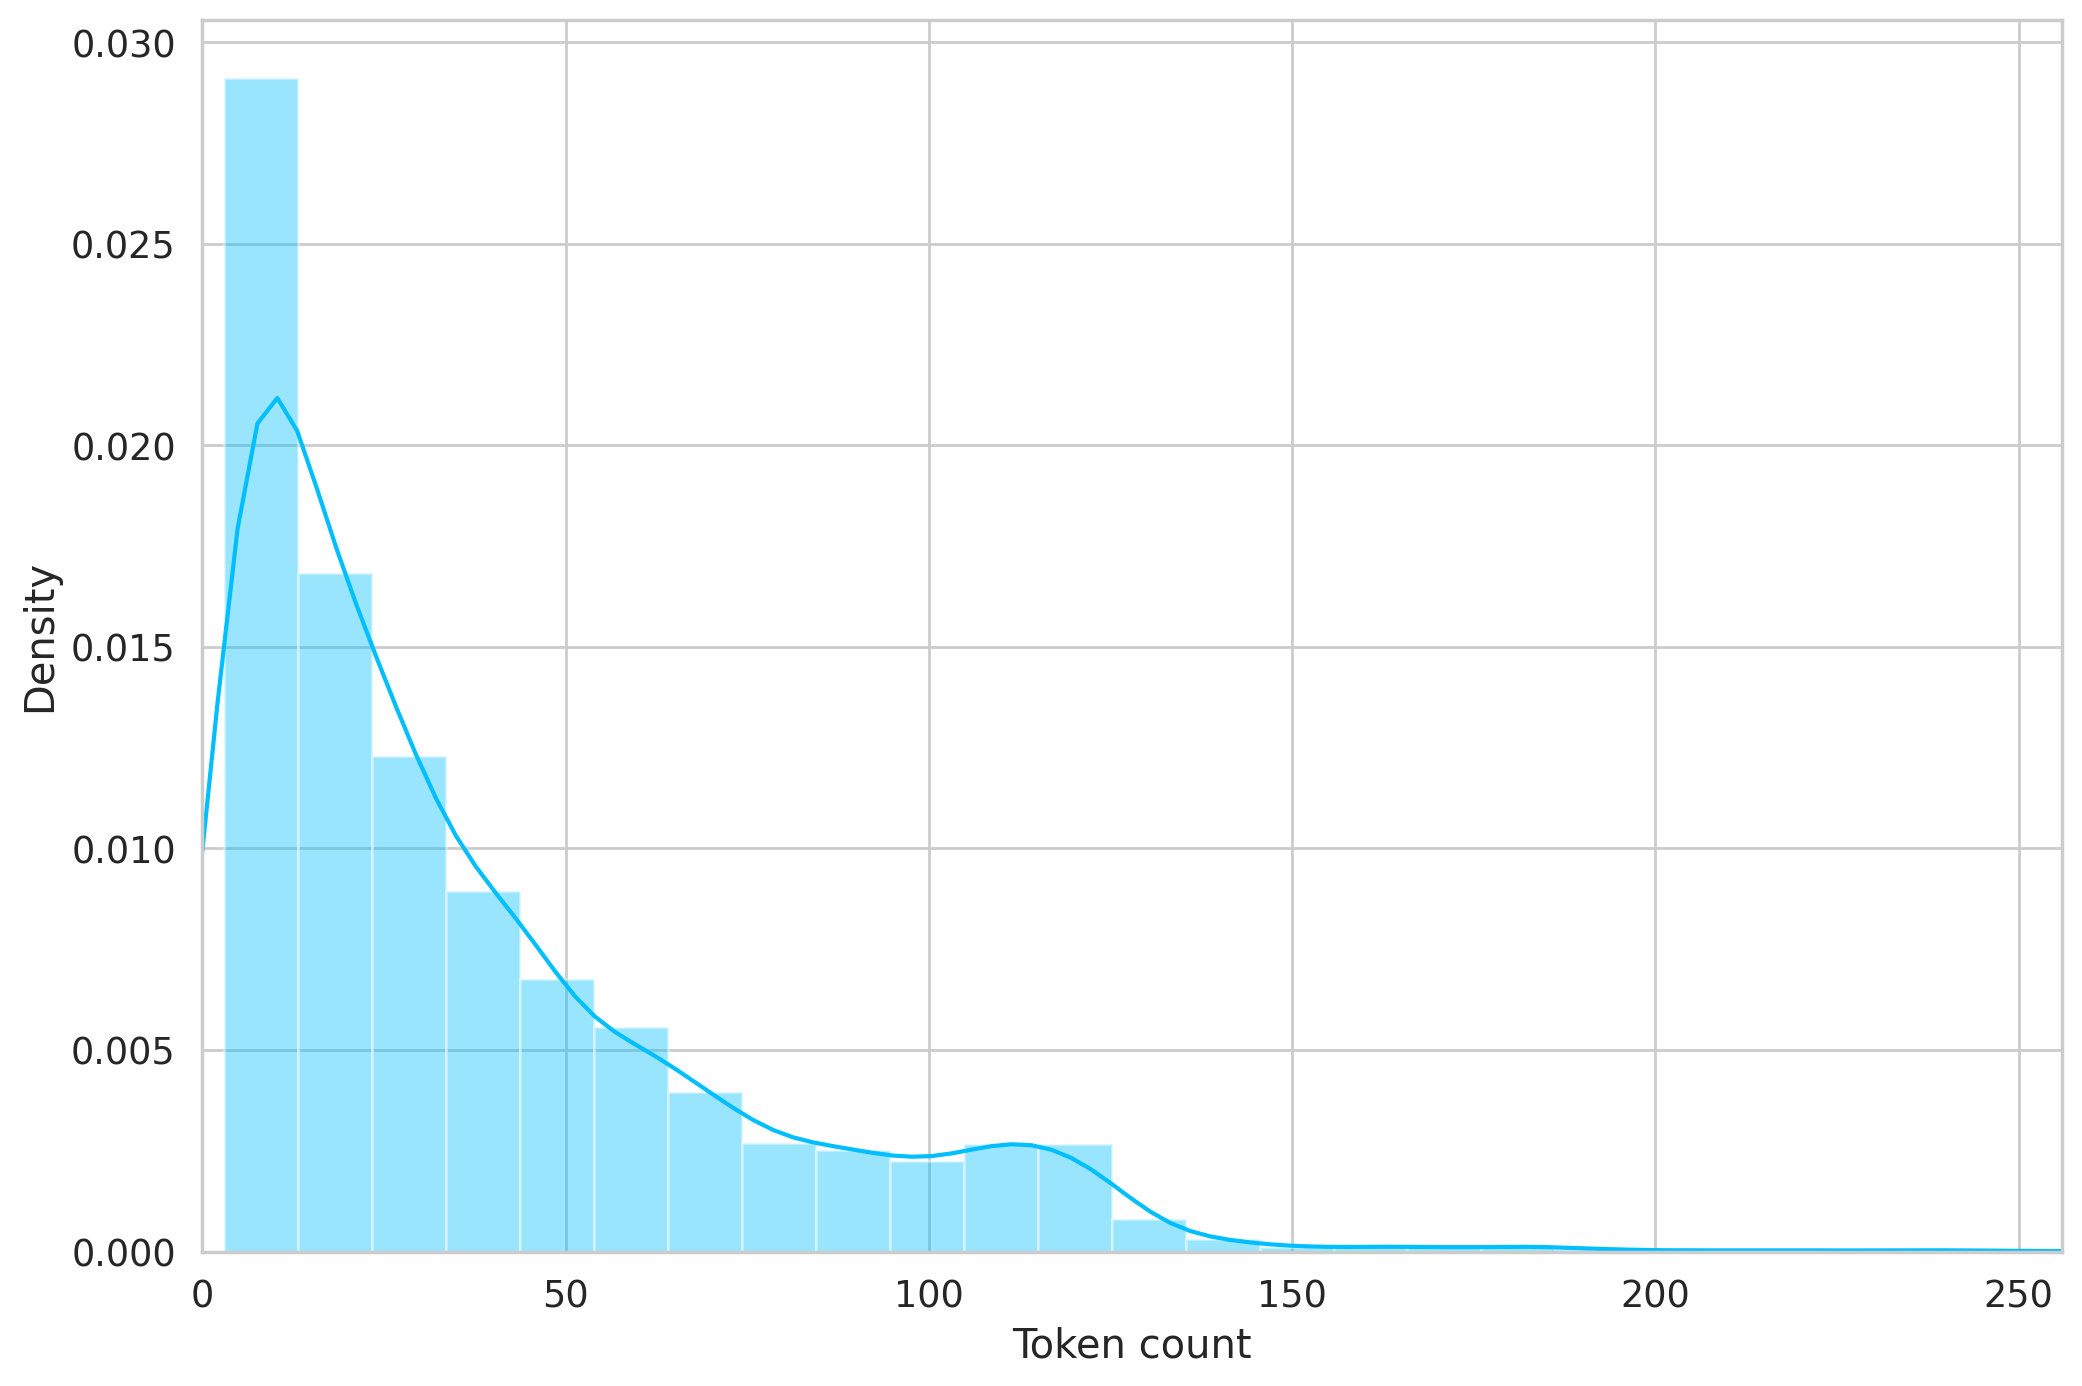

In [ ]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 160

# Dataset

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(9996, 13) (1249, 13) (1250, 13)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Load model

In [ ]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask, return_dict=False):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict = return_dict
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training loop

In [ ]:
# Number of iterations
EPOCHS = 10

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm.tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm.tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model, '/content/drive/MyDrive/Telecom/Airbus/Sentiment classification/Ternaire Sentiment Classification/ternary_sentiment_model.pth')
        best_accuracy = val_acc

Epoch 1/10


100%|██████████| 625/625 [04:19<00:00,  2.41it/s]


Train loss 0.6917954847097397 accuracy 0.722889155662265


100%|██████████| 79/79 [00:11<00:00,  6.90it/s]


Val   loss 0.5959024370848378 accuracy 0.7566052842273818

Epoch 2/10


100%|██████████| 625/625 [04:18<00:00,  2.42it/s]


Train loss 0.49537380496263506 accuracy 0.8066226490596239


100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Val   loss 0.6155283068177066 accuracy 0.7678142514011208

Epoch 3/10


100%|██████████| 625/625 [04:18<00:00,  2.42it/s]


Train loss 0.3632836818128824 accuracy 0.8695478191276511


100%|██████████| 79/79 [00:11<00:00,  7.00it/s]


Val   loss 0.7245053031210658 accuracy 0.755004003202562

Epoch 4/10


100%|██████████| 625/625 [04:18<00:00,  2.42it/s]


Train loss 0.2721046034432948 accuracy 0.9134653861544618


100%|██████████| 79/79 [00:11<00:00,  6.97it/s]


Val   loss 0.9204904224393489 accuracy 0.7534027221777422

Epoch 5/10


100%|██████████| 625/625 [04:18<00:00,  2.42it/s]


Train loss 0.20565379003472625 accuracy 0.9419767907162866


100%|██████████| 79/79 [00:11<00:00,  6.97it/s]


Val   loss 1.1506303523466745 accuracy 0.7526020816653323

Epoch 6/10


100%|██████████| 625/625 [04:17<00:00,  2.43it/s]


Train loss 0.16527927430979908 accuracy 0.9557823129251701


100%|██████████| 79/79 [00:11<00:00,  6.97it/s]


Val   loss 1.2925988130177124 accuracy 0.733386709367494

Epoch 7/10


100%|██████████| 625/625 [04:17<00:00,  2.43it/s]


Train loss 0.13493180700000376 accuracy 0.9642857142857143


100%|██████████| 79/79 [00:11<00:00,  6.94it/s]


Val   loss 1.3894304119498482 accuracy 0.7502001601281024

Epoch 8/10


100%|██████████| 625/625 [04:17<00:00,  2.42it/s]


Train loss 0.11071565000843257 accuracy 0.9735894357743098


100%|██████████| 79/79 [00:11<00:00,  7.01it/s]


Val   loss 1.4623622863798085 accuracy 0.7429943955164131

Epoch 9/10


100%|██████████| 625/625 [04:17<00:00,  2.43it/s]


Train loss 0.0974764427965507 accuracy 0.976390556222489


100%|██████████| 79/79 [00:11<00:00,  6.98it/s]


Val   loss 1.5440550639465027 accuracy 0.7429943955164131

Epoch 10/10


100%|██████████| 625/625 [04:17<00:00,  2.43it/s]


Train loss 0.08294162321584299 accuracy 0.9784913965586235


100%|██████████| 79/79 [00:11<00:00,  7.09it/s]

Val   loss 1.6092110677191964 accuracy 0.7341873498799039

CPU times: user 43min 57s, sys: 21.8 s, total: 44min 18s
Wall time: 44min 57s


# Post processing and results analysis

In [ ]:
train_acc=[]
for elem in history['train_acc']:
  train_acc.append(elem.cpu())

val_acc=[]
for elem in history['val_acc']:
  val_acc.append(elem.cpu())

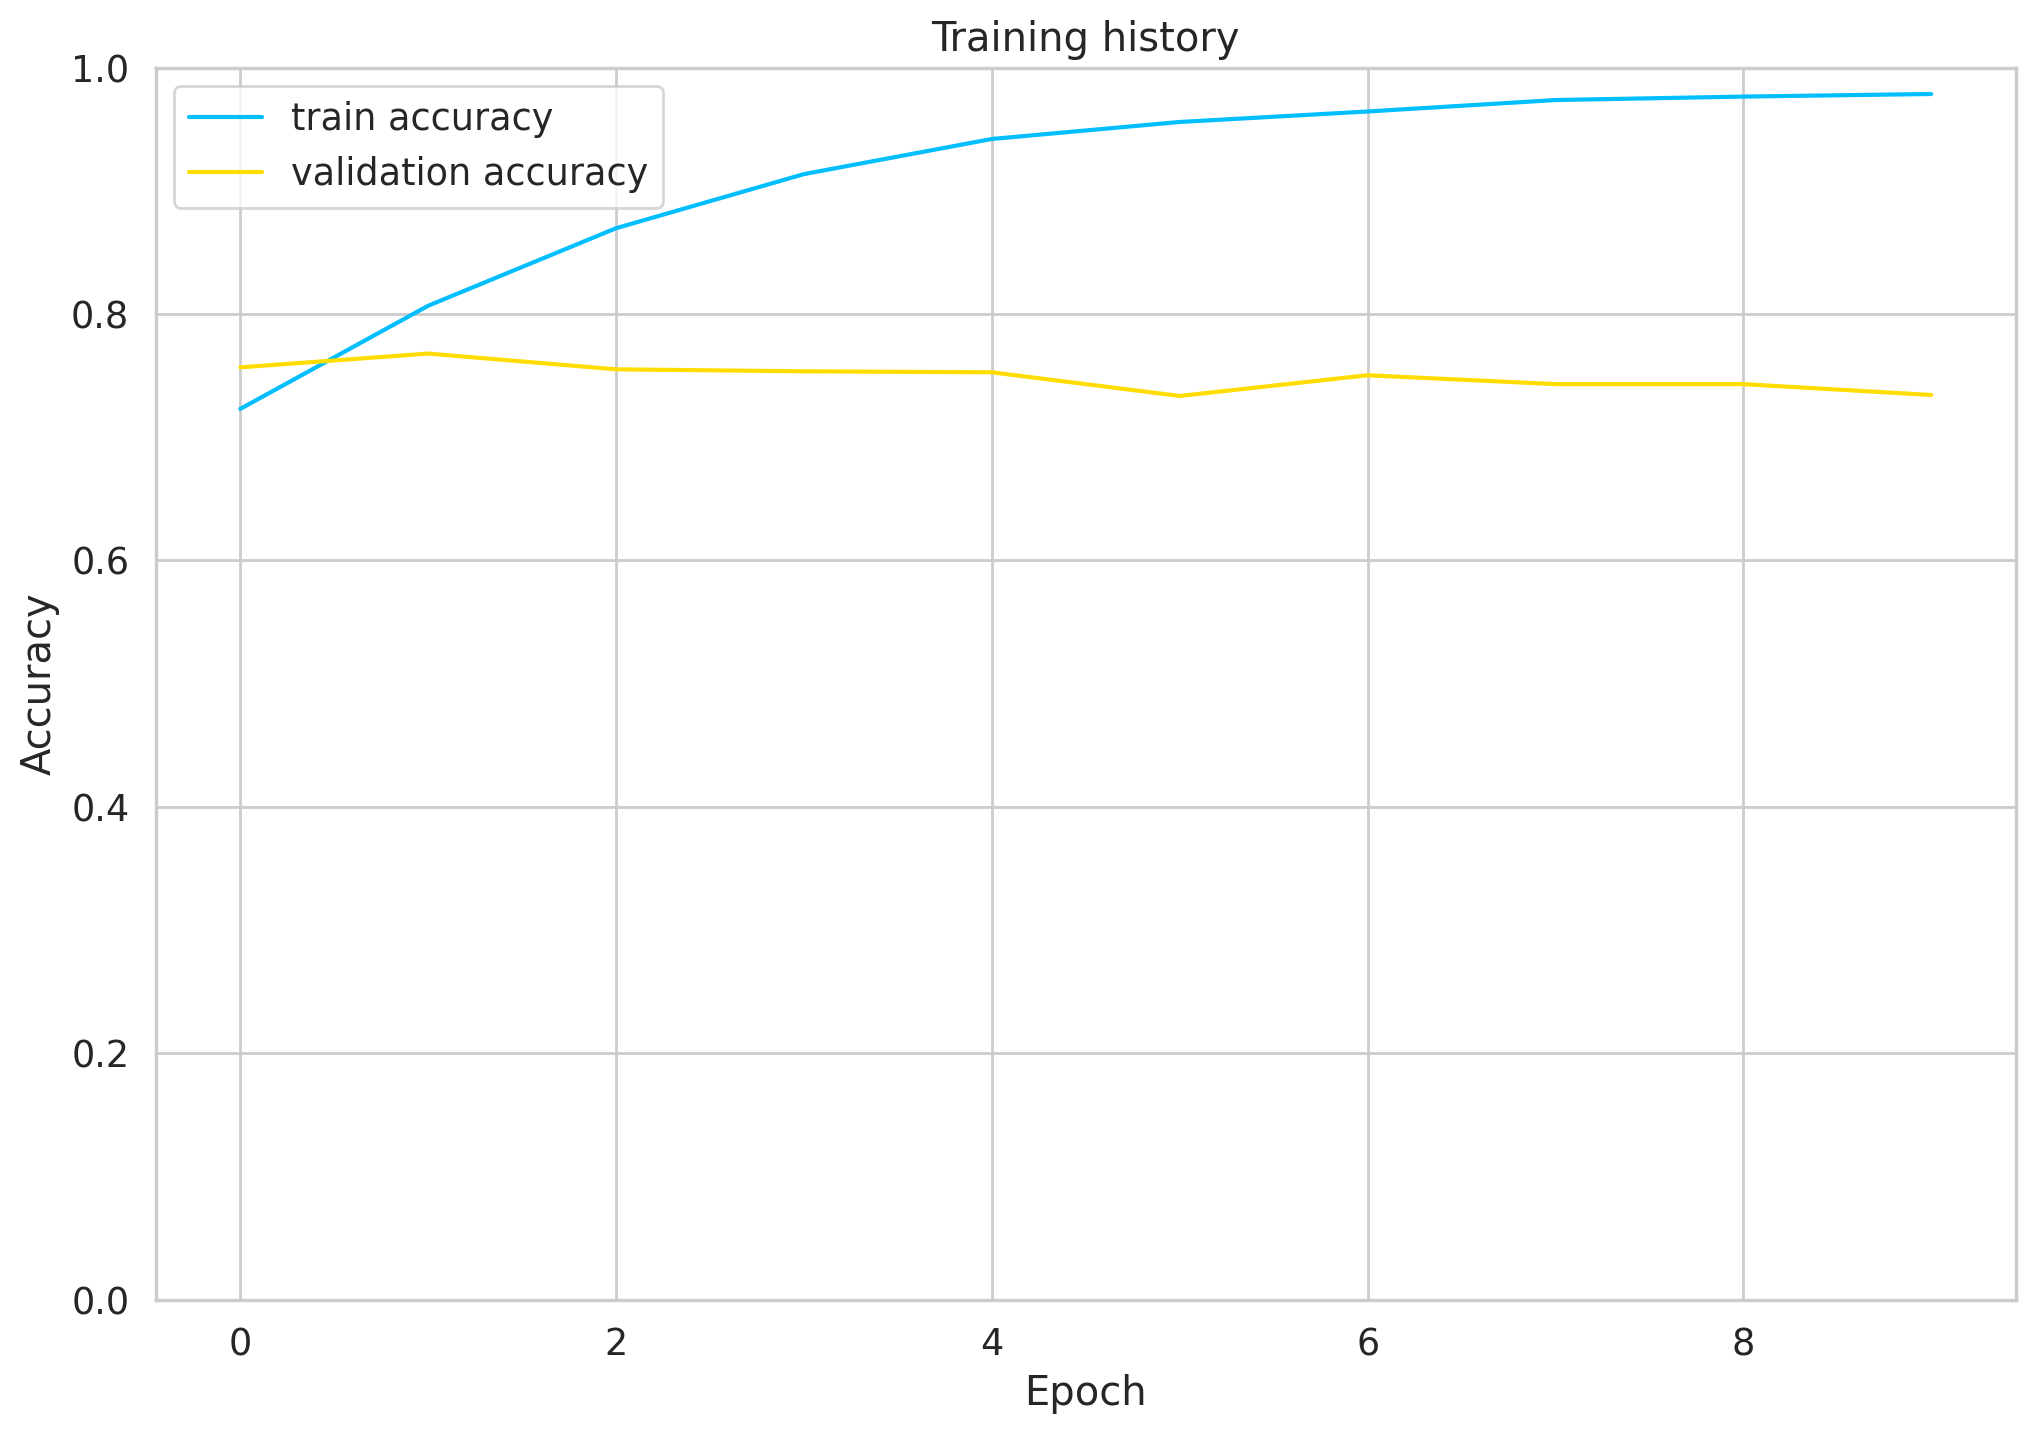

In [ ]:
# Plot training and validation accuracy
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

100%|██████████| 79/79 [00:11<00:00,  6.73it/s]


0.7240000000000001

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.75      0.76       480
     neutral       0.37      0.42      0.39       216
    positive       0.84      0.82      0.83       554

    accuracy                           0.72      1250
   macro avg       0.66      0.66      0.66      1250
weighted avg       0.73      0.72      0.73      1250



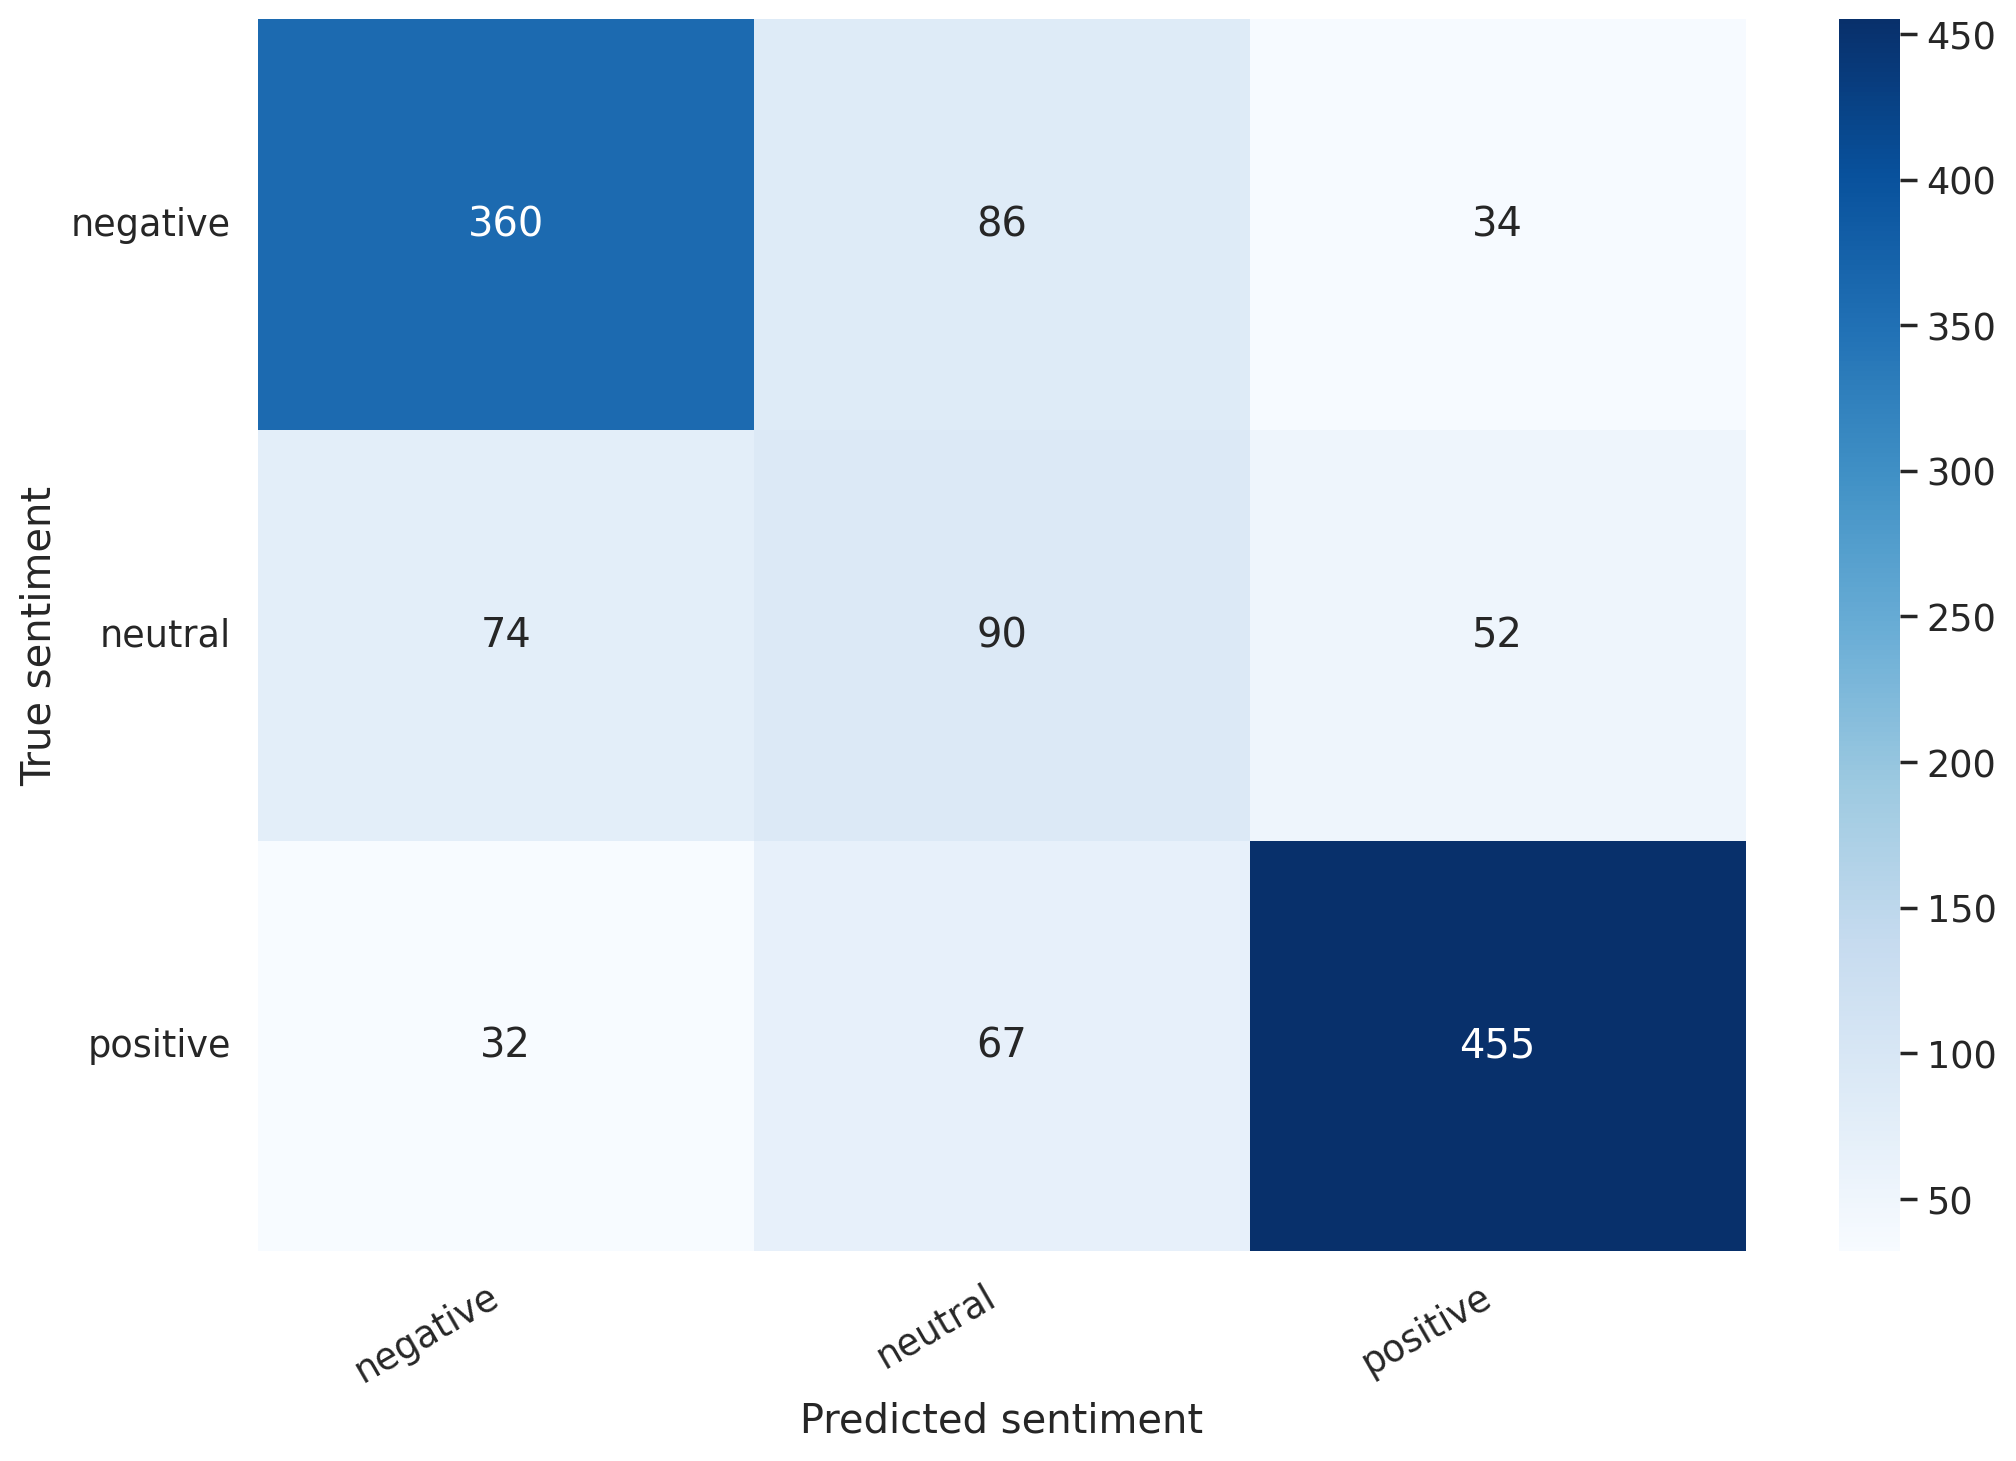

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Inference

In [ ]:
def predict_sentiment(model, tokenizer, text):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    print(f'Review text: {text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
texts_list = ["I'm not capable of doing it.", "I believe in myself.", "I don't see the point in trying.", "I'm excited to give it a shot.", "I'm not good enough.", "I'm capable of handling this.", "This is a disaster waiting to happen.", "This is a great opportunity to learn.", "I'm always so unlucky.", "I'm grateful for this experience.", "No pain, no gain.", "It's not you, it's me.", "It could have been worse.", "I'm not as young as I used to be.", "You're too good to be true.", "The weather today is partly cloudy.", "I ate a turkey sandwich for lunch.", "The book I'm reading is about history.", "My favorite color is blue.", "I need to go grocery shopping this weekend."]

for text in texts_list:
  predict_sentiment(model, tokenizer, text)

Review text: I'm not capable of doing it.
Sentiment  : negative
Review text: I believe in myself.
Sentiment  : positive
Review text: I don't see the point in trying.
Sentiment  : negative
Review text: I'm excited to give it a shot.
Sentiment  : positive
Review text: I'm not good enough.
Sentiment  : negative
Review text: I'm capable of handling this.
Sentiment  : positive
Review text: This is a disaster waiting to happen.
Sentiment  : negative
Review text: This is a great opportunity to learn.
Sentiment  : positive
Review text: I'm always so unlucky.
Sentiment  : neutral
Review text: I'm grateful for this experience.
Sentiment  : positive
Review text: No pain, no gain.
Sentiment  : negative
Review text: It's not you, it's me.
Sentiment  : positive
Review text: It could have been worse.
Sentiment  : neutral
Review text: I'm not as young as I used to be.
Sentiment  : neutral
Review text: You're too good to be true.
Sentiment  : negative
Review text: The weather today is partly cloudy.
Se